![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor  

# import

In [77]:
import numpy as np 
import pandas as pd 
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline


from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [2]:
# Фиксируем RANDOM_SEED, чтобы наши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Фиксируем сегодняшнюю дату
date_today = pd.to_datetime('2020-08-07')

In [5]:
pd.set_option('display.max_rows', 100) # выведем больше строк
pd.set_option('display.max_columns', 100) # выведем больше колонок

# DATA

In [6]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [8]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [9]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [10]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [12]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
11720,id_2101,Amsterdam,NaN,2106.0,NaN,5.0,"[['Great Lunch'], ['01/05/2017']]",/Restaurant_Review-g188590-d10815488-Reviews-D...,d10815488,1,5.0
14319,id_7854,London,['British'],7863.0,$,13.0,"[['Good location and good value', 'Good value ...",/Restaurant_Review-g186338-d10281458-Reviews-P...,d10281458,1,4.0
1419,id_1419,Lisbon,"['Portuguese', 'Vegetarian Friendly', 'Vegan O...",557.0,$$ - $$$,158.0,"[['Great service for a really big group', 'Gre...",/Restaurant_Review-g189158-d2615243-Reviews-Re...,d2615243,0,0.0
48106,id_4075,Paris,"['French', 'European']",4076.0,$$ - $$$,257.0,"[['Feel like a French student', 'Nice catch'],...",/Restaurant_Review-g187147-d1604128-Reviews-L_...,d1604128,1,3.5
24498,id_13539,Paris,NaN,13541.0,NaN,71.0,"[[""Don't come here for the food"", 'Nice but no...",/Restaurant_Review-g187147-d5932484-Reviews-Du...,d5932484,1,2.5


# Осмотр и обработка данных и генерация новых признаков

# City

Посмотрим на количество ресторанов в городе

In [13]:
data['City'].value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

Добавим данную информацию в отдельную переменную

In [14]:
df_tmp = data['City'].value_counts()

Добавим столбец rests - количество ресторанов в городе

In [15]:
data['rests'] = data['City'].apply(lambda x: df_tmp[x])

Поработаем с популяциями городов. 
Добавим столбец population из Википедии, https://en.wikipedia.org/wiki/List_of_cities_in_the_European_Union_by_population_within_city_limits

In [19]:
population_dict = {
    'London': 9304016,
    'Paris': 2140526,
    'Madrid': 3348536,
    'Barcelona': 1620343,
    'Berlin': 3748148,
    'Milan': 1404239,
    'Rome': 2856133,
    'Prague': 1324277,
    'Lisbon': 506654,
    'Vienna': 1911728,
    'Amsterdam': 873555,
    'Brussels': 1209000,
    'Hamburg': 1841179,
    'Munich': 1471508,
    'Lyon': 515695,
    'Stockholm': 974073,
    'Budapest': 1752286,
    'Warsaw': 1790658,
    'Dublin': 554554,
    'Copenhagen': 626508,
    'Athens': 664046,
    'Edinburgh': 524930,
    'Zurich': 415367,
    'Oporto': 237559,
    'Geneva': 201818,
    'Krakow': 779115,
    'Oslo': 693491,
    'Helsinki': 648042,
    'Bratislava': 432864,
    'Luxembourg': 613894,
    'Ljubljana': 292988
}

In [20]:
data['population'] = data['City'].map(population_dict)

"Пронормируем" столбец population (получим значения в тысячах жителей)

In [21]:
data['population'] = data['population'] / 1000

Добавим столбец rest_density плотности ресторанов в городе

In [22]:
data['rest_density'] = data.rests / data.population

Добавим признак country

In [23]:
countries_dict = {'Amsterdam': 'Netherlands',
             'Athens': 'Greece',
             'Barcelona': 'Spain',
             'Berlin': 'Germany',
             'Bratislava': 'Slovakia',
             'Brussels': 'Belgium',
             'Budapest': 'Hungary',
             'Copenhagen': 'Denmark',
             'Dublin': 'Ireland',
             'Edinburgh': 'UK',
             'Geneva': 'Switzerland',
             'Hamburg': 'Germany',
             'Helsinki': 'Finland',
             'Krakow': 'Poland',
             'Lisbon': 'Portugal',
             'Ljubljana': 'Slovenia',
             'London': 'UK',
             'Luxembourg': 'Luxembourg',
             'Lyon': 'France',
             'Madrid': 'Spain',
             'Milan': 'Italy',
             'Munich': 'Germany',
             'Oporto': 'Portugal',
             'Oslo': 'Norway',
             'Paris': 'France',
             'Prague': 'Czechia',
             'Rome': 'Italy',
             'Stockholm': 'Sweden',
             'Vienna': 'Austria',
             'Warsaw': 'Poland',
             'Zurich': 'Switzerland'}

data['country'] = data['City'].map(countries_dict)

Добавим dummies по странам

In [24]:
data = pd.get_dummies(data, columns=['country']) # , dummy_na=True # в странах пропусков нет
data.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,rests,population,rest_density,country_Austria,country_Belgium,country_Czechia,country_Denmark,country_Finland,country_France,country_Germany,country_Greece,country_Hungary,country_Ireland,country_Italy,country_Luxembourg,country_Netherlands,country_Norway,country_Poland,country_Portugal,country_Slovakia,country_Slovenia,country_Spain,country_Sweden,country_Switzerland,country_UK
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,6108,2140.526,2.853504,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,475,648.042,0.732977,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,745,524.930,1.419237,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Добавим dummies по городам

In [25]:
data = pd.concat([data, pd.get_dummies(data.City, prefix='City')], axis=1)
data.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,rests,population,rest_density,country_Austria,country_Belgium,country_Czechia,country_Denmark,country_Finland,country_France,country_Germany,country_Greece,country_Hungary,country_Ireland,country_Italy,country_Luxembourg,country_Netherlands,country_Norway,country_Poland,country_Portugal,country_Slovakia,country_Slovenia,country_Spain,country_Sweden,country_Switzerland,country_UK,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,6108,2140.526,2.853504,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,475,648.042,0.732977,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,745,524.930,1.419237,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Cuisine Style

Посмотрим на количество кухней

In [26]:
data['Cuisine Style'].value_counts()

['Italian']                                                                           1332
['French']                                                                            1019
['Spanish']                                                                            860
['French', 'European']                                                                 503
['Cafe']                                                                               500
                                                                                      ... 
['Latin', 'Venezuelan', 'Central American']                                              1
['Italian', 'Chinese', 'Japanese', 'Sushi', 'Fusion', 'Vegetarian Friendly']             1
['Polish', 'International', 'European', 'Diner']                                         1
['Bar', 'Pub', 'Portuguese']                                                             1
['European', 'Central European', 'German', 'International', 'Vegetarian Friendly']       1

Как мы видим данные "грязные"

Узнаем количество пустых значений

In [27]:
data['Cuisine Style'].isna().sum()

11590

Сохраним данную информацию в новом столбце 

In [28]:
data['cuisine_style_isna'] = pd.isna(data['Cuisine Style']).astype('uint8')

Заполним пустые значения и посмотрим на количество уникальных кухонь

In [29]:
data['Cuisine Style'].fillna('1', inplace=True)

data['cuisine'] = data['Cuisine Style'].str[1:-1].str.split(', ')
len(data.explode('cuisine')['cuisine'].value_counts())

126

Создадим новый признак cuisines_number - количество кухонь, представленных рестораном

In [30]:
data['cuisines_number'] = data['cuisine'].apply(lambda x: 1.0 if len(x)==0 else float(len(x)))

# Ranking

Посмотрим распределение признака

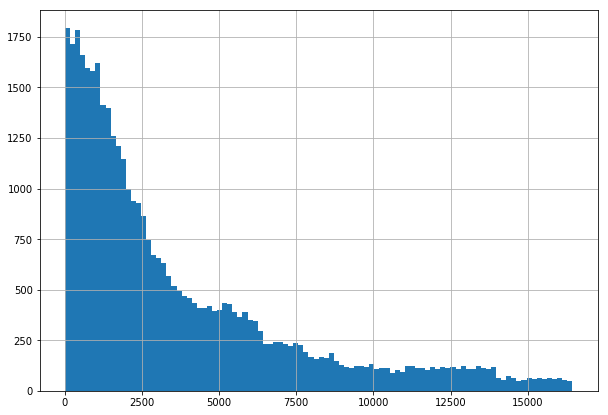

In [31]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

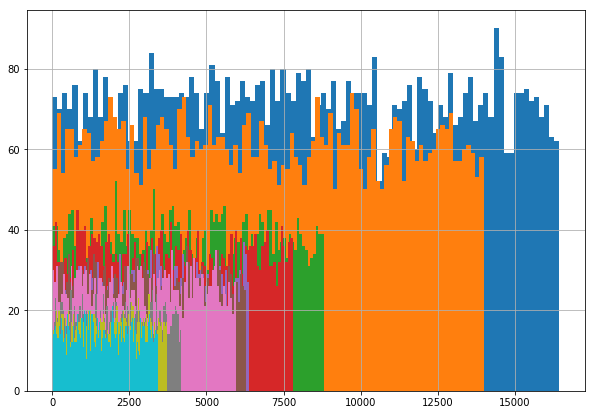

In [32]:
# Посмотрим на ranking в топ 10 городах
for x in (data['City'].value_counts())[:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет равномерное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение

Создадим новый признак путем нормирования Ranking к количеству ресторанов в городе

In [33]:
data['ranking_norm_rests'] = data.Ranking / data.rests

 # **Price Range**

Узнаем количество пустых значений 

In [34]:
data['Price Range'].isna().sum()

17361

В переменной достаточно много пропусков, поэтому сохраним информацию в новом столбце

In [35]:
data['price_range_isna'] = pd.isna(data['Price Range']).astype('uint8')

Посмотрим на признаки и определим число вхождений для каждой категории

In [36]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3

In [37]:
price_dict = {'$': 1, '$$ - $$$': 2, '$$$$': 3,}
data['Price Range'] = data['Price Range'].map(price_dict)

Посмотрим на распределение цены

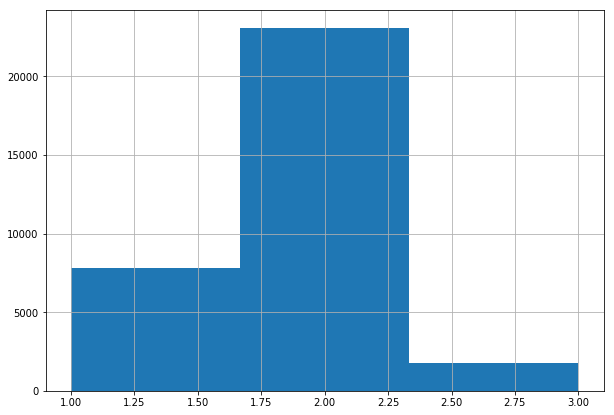

In [38]:
data['Price Range'].hist(bins=3)

Видим, что диапозон цен у большинства составлет 2.


Поэтому заполняем пропуски двойкой

In [39]:
data['Price Range'] = data['Price Range'].fillna(2)

# Number of Reviews

Узнаем количество пустых значений

In [40]:
data['Number of Reviews'].isna().sum()

3200

Сохраним информацию в новом столбце

In [41]:
data['number_reviews_isna'] = pd.isna(data['Number of Reviews']).astype('uint8')

Посмотрим на распределение количества отзывов

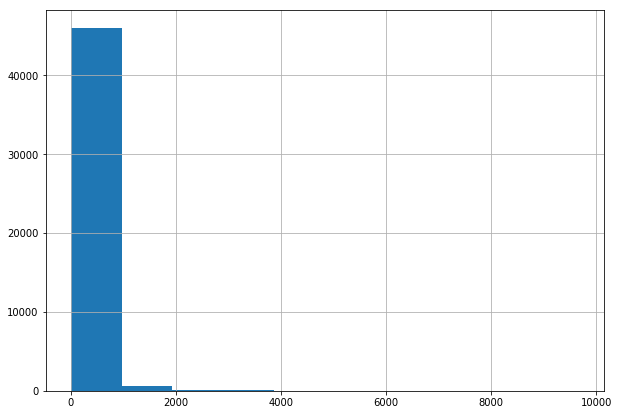

In [42]:
plt.rcParams['figure.figsize'] = (10,7)
data['Number of Reviews'].hist(bins=10)

Основное количество отзывов расположены по значению 0

Заполним пропуски значением 0

In [43]:
data['Number of Reviews'].fillna(0, inplace=True)

Создадим новый столбец reviews_number_norm - количество отзывов к населению города

In [44]:
data['reviews_number_norm'] = data['Number of Reviews'] / data['population']

# Reviews

Посмотрим на отзывы

In [45]:
data['Reviews'].value_counts(dropna=False)

[[], []]                                                                                                             8112
NaN                                                                                                                     2
[['Great Asian Option', 'Wow'], ['10/16/2017', '09/07/2016']]                                                           2
[['Enjoyable restaurant with indoor and outdo...', 'Delicious food'], ['11/04/2017', '10/31/2017']]                     2
[['Delicious soup', 'My weekly treat'], ['03/19/2017', '07/30/2017']]                                                   2
                                                                                                                     ... 
[['Quiet but delicious kosher cuisine!'], ['06/29/2014']]                                                               1
[['Particular experience', 'Cozy place at an affordable price'], ['07/01/2017', '06/28/2017']]                          1
[['Tasty food - well wor

Заполним пропуски

In [46]:
data['Reviews'].fillna('[[], []]', inplace=True)

Создадим новую колонку reviews_dates - даты отзывов

In [47]:
data['reviews_dates'] = data['Reviews'].str.findall('\d+/\d+/\d+')

Создадим новый столбец reviews_dates_count - количество отзывов

In [48]:
data['reviews_dates_count'] = data.reviews_dates.apply(lambda x: len(x))

Создадим столбцы для дат с отзывами

In [49]:
data['review1_date'] = data.reviews_dates.apply(lambda x: x[1] if len(x)==3 else x[0] if len(x)>0 else None)
data['review2_date'] = data.reviews_dates.apply(lambda x: x[2] if len(x)==3 else x[1] if len(x)>1 else None)
data['review1_date_d'] = data.review1_date.apply(lambda x: None if pd.isna(x) else datetime.strptime(x, '%m/%d/%Y'))
data['review2_date_d'] = data.review2_date.apply(lambda x: None if pd.isna(x) else datetime.strptime(x, '%m/%d/%Y'))

Создадим новый признак - количество дней между отзывами

In [50]:
data['days_between'] = ((data.review1_date_d - data.review2_date_d).dt.days)
data['days_between'].max()

3296.0

Посмотрим на распределение количества дней между отзывами

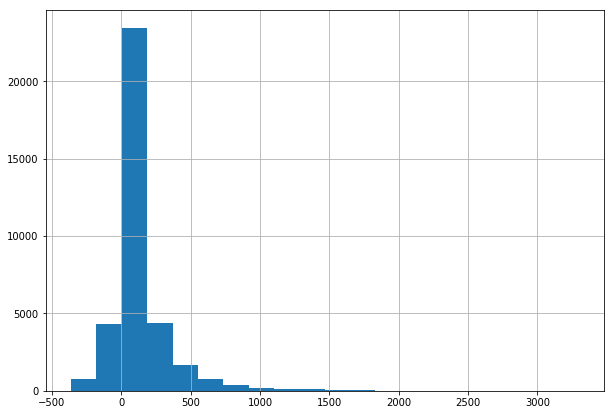

In [51]:
plt.rcParams['figure.figsize'] = (10,7)
data['days_between'].hist(bins=20)

Заполним пропуски значением 0

In [52]:
data.days_between.fillna(0, inplace=True)

Создадим новый признак - количество дней между последним отзывом и сегодняшней датой

In [53]:
data['days_to_today'] = ((date_today - data.review1_date_d).dt.days)

Узнаем количество пустых значений и посмотрим на распределение данного признака

8114

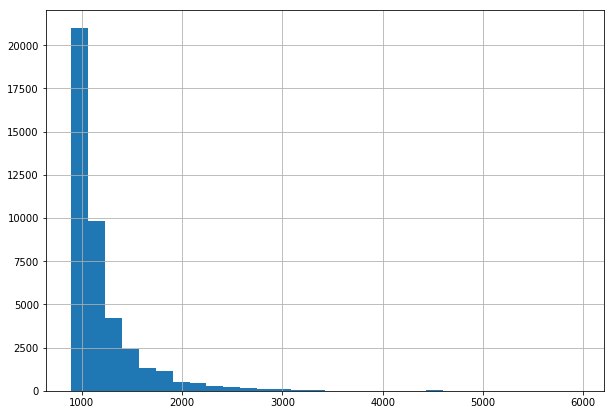

In [54]:
plt.rcParams['figure.figsize'] = (10,7)
data['days_to_today'].hist(bins=30)
data['days_to_today'].isna().sum()

Заполним пропуски

In [55]:
data['days_to_today'].fillna(data.days_to_today.median(), inplace=True)

# URL_TA

Посмотрим на данный признак

In [56]:
data['URL_TA'].value_counts()

/Restaurant_Review-g187514-d3748757-Reviews-D_O_C_C_Prado-Madrid.html                                      2
/Restaurant_Review-g187514-d12488993-Reviews-Kathmandu_Tandoori_House_Nepali_Indian_Cuisine-Madrid.html    2
/Restaurant_Review-g187514-d8753348-Reviews-Tropecientos-Madrid.html                                       2
/Restaurant_Review-g187514-d11698990-Reviews-Verdello_Restaurante-Madrid.html                              2
/Restaurant_Review-g187514-d1315077-Reviews-El_Pimiento_Verde-Madrid.html                                  2
                                                                                                          ..
/Restaurant_Review-g186338-d6155929-Reviews-Tierra_Verde-London_England.html                               1
/Restaurant_Review-g806262-d9705632-Reviews-Cafe_La_Tete-Frederiksberg_Copenhagen_Zealand.html             1
/Restaurant_Review-g187147-d10222629-Reviews-Le_Compere-Paris_Ile_de_France.html                           1
/Restaurant_Review-

Данный признак не имеет полезной информации

# ID_TA

Посмотрим на данный признак

In [57]:
data['ID_TA'].value_counts()

d7342803     2
d2669414     2
d1315077     2
d793170      2
d2477531     2
            ..
d10840307    1
d4823827     1
d6988285     1
d3585064     1
d7117330     1
Name: ID_TA, Length: 49963, dtype: int64

Преобразуем ID_TA в числа (будет новый признак)

In [58]:
data['id_ta_num'] = data['ID_TA'].str[1:].astype('int64')

# Корреляция признаков

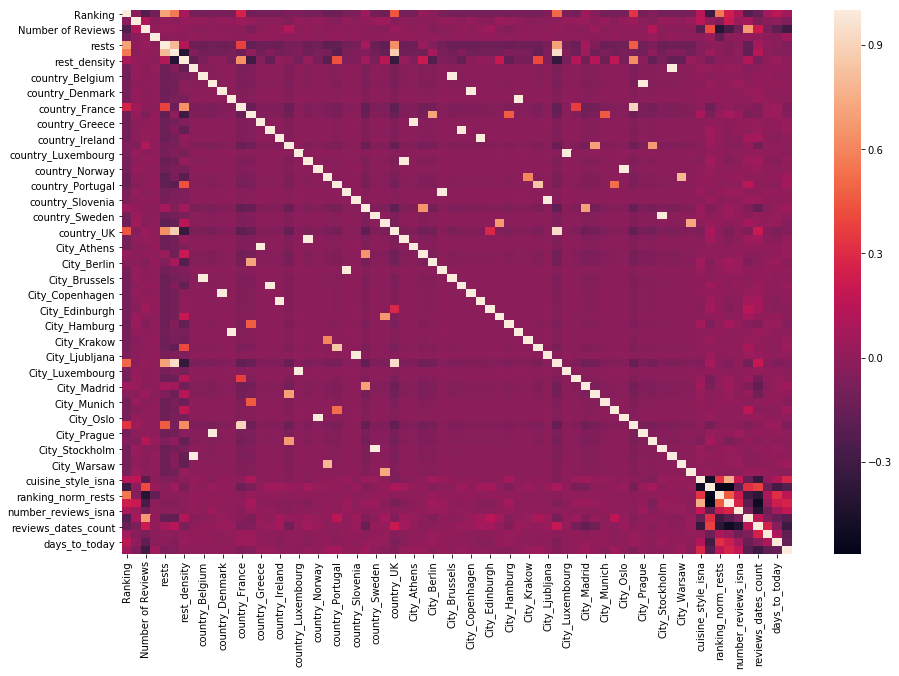

In [59]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

# Готовим данные для использования в моделе

In [60]:
data.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating',
       'rests', 'population', 'rest_density', 'country_Austria',
       'country_Belgium', 'country_Czechia', 'country_Denmark',
       'country_Finland', 'country_France', 'country_Germany',
       'country_Greece', 'country_Hungary', 'country_Ireland', 'country_Italy',
       'country_Luxembourg', 'country_Netherlands', 'country_Norway',
       'country_Poland', 'country_Portugal', 'country_Slovakia',
       'country_Slovenia', 'country_Spain', 'country_Sweden',
       'country_Switzerland', 'country_UK', 'City_Amsterdam', 'City_Athens',
       'City_Barcelona', 'City_Berlin', 'City_Bratislava', 'City_Brussels',
       'City_Budapest', 'City_Copenhagen', 'City_Dublin', 'City_Edinburgh',
       'City_Geneva', 'City_Hamburg', 'City_Helsinki', 'City_Krakow',
       'City_Lisbon', 'City_Ljubljana', 'City_London', 'City_Luxembourg',
     

In [61]:
df_preproc = data.drop(['Restaurant_id', 'Cuisine Style', 'Price Range', 'URL_TA', 'ID_TA',
                      'cuisine', 'reviews_dates', 'review1_date', 'review2_date', 'review1_date_d',
                      'review2_date_d', 'reviews_dates_count', 'rests', 'population', 'Reviews', 'City'], axis = 1)


# Разделим данные по признаку sample на тренировочные и тестовые

In [62]:
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [63]:
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [64]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 66), (40000, 66), (40000, 65), (32000, 65), (8000, 65))

# Model 

In [65]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [66]:
# Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [67]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [68]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.198929375


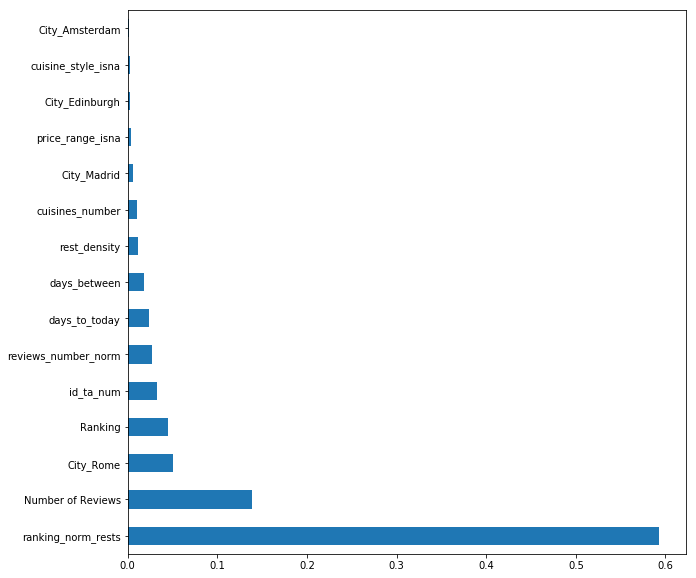

In [69]:
# Выведим самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission

In [70]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,rest_density,country_Austria,country_Belgium,country_Czechia,country_Denmark,country_Finland,country_France,country_Germany,country_Greece,country_Hungary,country_Ireland,country_Italy,country_Luxembourg,country_Netherlands,country_Norway,country_Poland,country_Portugal,country_Slovakia,country_Slovenia,country_Spain,country_Sweden,country_Switzerland,country_UK,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,cuisine_style_isna,cuisines_number,ranking_norm_rests,price_range_isna,number_reviews_isna,reviews_number_norm,days_between,days_to_today,id_ta_num
8141,4484.0,12.0,0.0,0.906470,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4.0,1.731943,0,0,0.004201,0.0,1061.0,10598377
8592,701.0,3.0,0.0,1.649144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.0,1.023358,1,0,0.007223,0.0,1027.0,12826604
3199,2047.0,3.0,0.0,0.754814,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1.0,1.418572,1,0,0.001569,0.0,1061.0,8068602
7207,5796.0,22.0,0.0,2.853504,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1.0,0.948919,1,0,0.010278,0.0,1061.0,3203913
5249,3183.0,51.0,0.0,0.721690,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,1.176710,0,0,0.013607,14.0,1083.0,4106911
1714,825.0,8.0,0.0,0.516570,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1.0,0.891892,1,0,0.004468,42.0,1409.0,10595068
5032,1137.0,336.0,0.0,2.853504,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2.0,0.186149,0,0,0.156971,83.0,1077.0,2223795
5025,137.0,890.0,0.0,2.702487,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,4.0,0.213396,0,0,3.746438,54.0,927.0,1315975
906,889.0,15.0,0.0,1.371314,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3.0,0.489537,0,0,0.011327,223.0,947.0,11826818
9419,2129.0,50.0,0.0,1.918477,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0,0.790275,0,0,0.035606,0.0,1613.0,5489791


In [71]:
test_data = test_data.drop(['Rating'], axis=1)

In [72]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [73]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [74]:
predict_submission

array([3.03 , 4.245, 4.185, ..., 3.03 , 4.485, 4.245])

In [76]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.030
1,id_1,4.245
2,id_2,4.185
3,id_3,4.340
4,id_4,4.470
5,id_5,4.480
6,id_6,2.460
7,id_7,2.245
8,id_8,4.050
9,id_9,4.585
